In [55]:
import os
import cv2
import numpy as np
from tqdm import tqdm
import pandas as pd
import glob
from scipy.ndimage import gaussian_filter


## Get image data, count types, construct training data

In [56]:
REBUILD_DATA = True

class IMGproc():
    #we can reduce the size of the image to try and reduce the amount of data per image
    img_size = 100
    
    #dictionary of labels and values
    labels = {'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'nv': 4, 'mel': 5, 'vasc': 6}
    
    training_data = []
    akiec_count = 0
    bcc_count = 0
    bkl_count = 0
    df_count = 0
    nv_count = 0
    mel_count = 0
    vasc_count = 0
    
    #look up and load image files and labels based on metadata
    def make_training_data(self):
        ham_meta = pd.read_csv('HAM10000_metadata.csv')
        image_files_1 = glob.glob('HAM10000_images_part_1/*')
        image_files_2 = glob.glob('HAM10000_images_part_2/*')
        image_files = np.concatenate((np.array(image_files_1), np.array(image_files_2)), axis=0)
        
        #if we want to limit the number of images so that all images have the same amount
        count_limit = 99999 
        #loop through image files
        for i in tqdm(range(len(image_files))):
            
            try:
                #get image name
                img_name = image_files[i].split('/')[1][:-4]
                #check image name with image_id
                img_dex = np.where(ham_meta['image_id'].values == img_name)[0][0]
                #check cancer type
                dx_type = ham_meta['dx'][img_dex]
                #check if cancer type has reached limit
                if dx_type == 'akiec':
                    if self.akiec_count >= count_limit:
                        continue
                if dx_type == 'bcc':
                    if self.bcc_count >= count_limit:
                        continue
                if dx_type == 'bkl':
                    if self.bkl_count >= count_limit:
                        continue
                if dx_type == 'df':
                    if self.df_count >= count_limit:
                        continue
                if dx_type == 'nv':
                    if self.nv_count >= count_limit:
                        continue
                if dx_type == 'mel':
                    if self.mel_count >= count_limit:
                        continue
                if dx_type == 'vasc':
                    if self.vasc_count >= count_limit:
                        continue
                #Load image in grayscale
                img = cv2.imread(image_files[i], cv2.IMREAD_GRAYSCALE)
                #Reduce image size
                img = cv2.resize(img, (self.img_size, self.img_size))
                #add blur
                #img = gaussian_filter(img, sigma = 1)
                #Add to training data
                self.training_data.append([np.array(img), np.eye(7)[self.labels[dx_type]]])

                if dx_type == 'akiec':
                    self.akiec_count += 1
                elif dx_type == 'bcc':
                    self.bcc_count += 1
                elif dx_type == 'bkl':
                    self.bkl_count += 1
                elif dx_type == 'df':
                    self.df_count += 1
                elif dx_type == 'nv':
                    self.nv_count += 1
                elif dx_type == 'mel':
                    self.mel_count += 1
                elif dx_type == 'vasc':
                    self.vasc_count += 1
            except Exception as e:
                print(str(e))
            
        #Shuffle training data
        np.random.shuffle(self.training_data)
        np.save('training_data.npy', self.training_data)
        print('akiec:', self.akiec_count)
        print('bcc:', self.bcc_count)
        print('bkl:', self.bkl_count)
        print('df:', self.df_count)
        print('nv:', self.nv_count)
        print('mel:', self.mel_count)
        print('vasc:', self.vasc_count)
        
if REBUILD_DATA:
    img_proc = IMGproc()
    img_proc.make_training_data()
    

100%|██████████| 10015/10015 [01:55<00:00, 86.51it/s]
/Users/georgevejar/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


akiec: 327
bcc: 514
bkl: 1099
df: 115
nv: 6705
mel: 1113
vasc: 142


## Check data

In [57]:
training_data = np.load('training_data.npy', allow_pickle=True)

In [58]:
print(len(training_data))

10015


In [59]:
print(len(training_data[0][0]))

100


In [60]:
print(training_data[1])

[array([[161, 160, 156, ..., 166, 169, 168],
        [155, 154, 159, ..., 166, 170, 167],
        [150, 148, 151, ..., 164, 171, 165],
        ...,
        [150, 156, 152, ..., 156, 153, 147],
        [151, 156, 158, ..., 151, 155, 151],
        [153, 157, 152, ..., 154, 152, 144]], dtype=uint8)
 array([0., 0., 0., 0., 1., 0., 0.])]


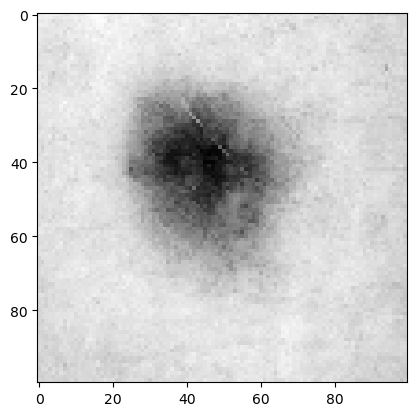

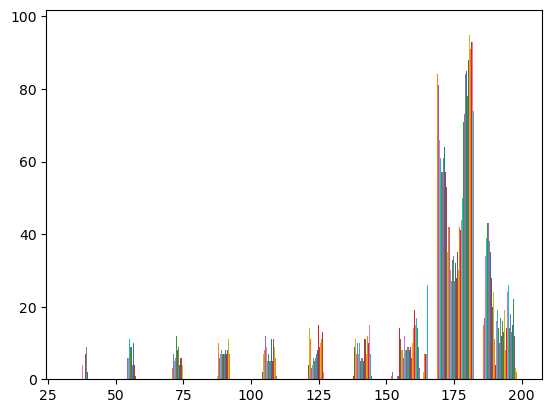

In [61]:
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

img = 36
plt.imshow(training_data[img][0], cmap = 'gray')
plt.show()
plt.hist(training_data[img][0])
plt.show()
# result = gaussian_filter(training_data[img][0], sigma=1)
# #training_data[img][0][np.where(training_data[img][0] >= 160)] = 0
# plt.imshow(result, cmap = 'gray')
# plt.show()
# plt.hist(result)
# plt.show()

## Create Neural Net

In [62]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        #Convolutional layers
        self.conv1 = nn.Conv2d(1,32, 5) # input is 1 image, 32 output channels, 5x5 kernel / window
        self.conv2 = nn.Conv2d(32,64, 5) # input is 32, bc the first layer output 32. Then we say the output will be 64 channels, 5x5 conv
        self.conv3 = nn.Conv2d(64,128, 5)
        
        #test data
        x = torch.randn(100,100).view(-1,1,100,100)
        self._to_linear = None
        self.convs(x)
        #linear fully connected layers
        self.fc1 = nn.Linear(self._to_linear, 512) #flattening
        self.fc2 = nn.Linear(512, 7) # 512 in, 7 out bc we're doing 7 classes
        
    def convs(self, x):
        #max pooling and relu
        x = F.max_pool2d(F.relu(self.conv1(x)), (2,2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2,2))
        x = F.max_pool2d(F.relu(self.conv3(x)), (2,2))
        
        print(x[0].shape)
        if self._to_linear is None:
            self._to_linear = x[0].shape[0]*x[0].shape[1]*x[0].shape[2]
        return x
    
    def forward(self, x):
        x = self.convs(x)
        x = x.view(-1, self._to_linear) # .view is reshape ... this flattens X before
        x = F.relu(self.fc1(x))
        x = self.fc2(x) # bc this is our output layer. No activation here.
        return F.softmax(x, dim=1)


net = Net()
print(net)

torch.Size([128, 9, 9])
Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=10368, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=7, bias=True)
)


In [63]:
import torch.optim as optim

optimizer = optim.Adam(net.parameters(), lr = 0.001)
loss_function = nn.MSELoss()

X = torch.Tensor([i[0] for i in training_data]).view(-1, 100,100)
X = X/255.0
y = torch.Tensor([i[1] for i in training_data])

VAL_PCT = 0.2 # lets reserve 20% of our data for validation
val_size = int(len(X)*VAL_PCT)
print(val_size)

2003


In [64]:
train_X = X[:-val_size]
train_y = y[:-val_size]

test_X = X[-val_size:]
test_y = y[-val_size:]

print(len(train_X))
print(len(test_X))

8012
2003


In [65]:
BATCH_SIZE = 10
EPOCHS = 1

for epoch in range(EPOCHS):
    for i in tqdm(range(0, len(train_X), BATCH_SIZE)): # from 0, to the len of x, stepping BATCH_SIZE at a time.
        #print(i, i+BATCH_SIZE)
        batch_X = train_X[i:i+BATCH_SIZE].view(-1, 1, 100,100)
        batch_y = train_y[i:i+BATCH_SIZE]
        
        net.zero_grad()
        outputs = net(batch_X)
        #print(len(outputs), len(batch_y))
        loss = loss_function(outputs, batch_y)
        loss.backward()
        optimizer.step() # Does the update
        
print(loss)

  0%|          | 0/802 [00:00<?, ?it/s]

torch.Size([128, 9, 9])


  0%|          | 2/802 [00:00<04:06,  3.25it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


  0%|          | 4/802 [00:01<03:17,  4.03it/s]

torch.Size([128, 9, 9])


  1%|          | 5/802 [00:01<03:09,  4.21it/s]

torch.Size([128, 9, 9])


  1%|          | 6/802 [00:01<03:02,  4.36it/s]

torch.Size([128, 9, 9])


  1%|          | 7/802 [00:01<02:55,  4.52it/s]

torch.Size([128, 9, 9])


  1%|          | 8/802 [00:01<02:52,  4.61it/s]

torch.Size([128, 9, 9])


  1%|          | 9/802 [00:02<02:50,  4.64it/s]

torch.Size([128, 9, 9])


  1%|          | 10/802 [00:02<02:49,  4.68it/s]

torch.Size([128, 9, 9])


  1%|▏         | 11/802 [00:02<02:52,  4.58it/s]

torch.Size([128, 9, 9])


  1%|▏         | 12/802 [00:02<02:59,  4.39it/s]

torch.Size([128, 9, 9])


  2%|▏         | 13/802 [00:03<03:00,  4.38it/s]

torch.Size([128, 9, 9])


  2%|▏         | 14/802 [00:03<03:04,  4.28it/s]

torch.Size([128, 9, 9])


  2%|▏         | 15/802 [00:03<02:59,  4.38it/s]

torch.Size([128, 9, 9])


  2%|▏         | 16/802 [00:03<02:54,  4.50it/s]

torch.Size([128, 9, 9])


  2%|▏         | 17/802 [00:03<02:50,  4.61it/s]

torch.Size([128, 9, 9])


  2%|▏         | 18/802 [00:04<02:46,  4.71it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


  2%|▏         | 20/802 [00:04<02:41,  4.85it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


  3%|▎         | 22/802 [00:04<02:38,  4.91it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


  3%|▎         | 24/802 [00:05<03:22,  3.84it/s]

torch.Size([128, 9, 9])


  3%|▎         | 25/802 [00:05<03:10,  4.08it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


  3%|▎         | 26/802 [00:06<04:31,  2.85it/s]

torch.Size([128, 9, 9])


  3%|▎         | 27/802 [00:07<06:00,  2.15it/s]

torch.Size([128, 9, 9])


  3%|▎         | 28/802 [00:07<05:58,  2.16it/s]

torch.Size([128, 9, 9])


  4%|▎         | 29/802 [00:08<05:58,  2.16it/s]

torch.Size([128, 9, 9])


  4%|▎         | 30/802 [00:08<07:33,  1.70it/s]

torch.Size([128, 9, 9])


  4%|▍         | 31/802 [00:09<07:02,  1.82it/s]

torch.Size([128, 9, 9])


  4%|▍         | 32/802 [00:09<06:40,  1.92it/s]

torch.Size([128, 9, 9])


  4%|▍         | 33/802 [00:10<06:58,  1.84it/s]

torch.Size([128, 9, 9])


  4%|▍         | 34/802 [00:10<06:09,  2.08it/s]

torch.Size([128, 9, 9])


  4%|▍         | 35/802 [00:11<05:32,  2.31it/s]

torch.Size([128, 9, 9])


  5%|▍         | 37/802 [00:11<04:43,  2.70it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


  5%|▍         | 38/802 [00:11<04:02,  3.16it/s]

torch.Size([128, 9, 9])


  5%|▍         | 39/802 [00:12<03:51,  3.29it/s]

torch.Size([128, 9, 9])


  5%|▍         | 40/802 [00:12<03:58,  3.19it/s]

torch.Size([128, 9, 9])


  5%|▌         | 42/802 [00:13<03:37,  3.49it/s]

torch.Size([128, 9, 9])


  5%|▌         | 43/802 [00:13<03:21,  3.76it/s]

torch.Size([128, 9, 9])


  5%|▌         | 44/802 [00:13<03:08,  4.03it/s]

torch.Size([128, 9, 9])


  6%|▌         | 45/802 [00:13<02:57,  4.27it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


  6%|▌         | 47/802 [00:14<02:58,  4.22it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


  6%|▌         | 49/802 [00:14<02:54,  4.31it/s]

torch.Size([128, 9, 9])


  6%|▌         | 50/802 [00:14<02:46,  4.52it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


  6%|▋         | 52/802 [00:15<02:35,  4.81it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


  7%|▋         | 54/802 [00:15<02:35,  4.81it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


  7%|▋         | 56/802 [00:16<02:39,  4.68it/s]

torch.Size([128, 9, 9])


  7%|▋         | 57/802 [00:16<02:36,  4.75it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


  7%|▋         | 58/802 [00:16<03:33,  3.49it/s]

torch.Size([128, 9, 9])


  7%|▋         | 59/802 [00:17<03:57,  3.13it/s]

torch.Size([128, 9, 9])


  7%|▋         | 60/802 [00:17<03:56,  3.14it/s]

torch.Size([128, 9, 9])


  8%|▊         | 61/802 [00:17<04:23,  2.81it/s]

torch.Size([128, 9, 9])


  8%|▊         | 63/802 [00:18<04:05,  3.01it/s]

torch.Size([128, 9, 9])


  8%|▊         | 64/802 [00:18<03:35,  3.43it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


  8%|▊         | 66/802 [00:19<02:58,  4.13it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


  8%|▊         | 68/802 [00:19<03:11,  3.84it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


  9%|▊         | 70/802 [00:20<03:11,  3.82it/s]

torch.Size([128, 9, 9])


  9%|▉         | 71/802 [00:20<02:56,  4.14it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


  9%|▉         | 72/802 [00:20<02:46,  4.39it/s]

torch.Size([128, 9, 9])


  9%|▉         | 73/802 [00:20<02:53,  4.19it/s]

torch.Size([128, 9, 9])


  9%|▉         | 74/802 [00:21<03:10,  3.82it/s]

torch.Size([128, 9, 9])


  9%|▉         | 75/802 [00:21<03:54,  3.10it/s]

torch.Size([128, 9, 9])


 10%|▉         | 77/802 [00:22<03:21,  3.60it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 10%|▉         | 79/802 [00:22<02:57,  4.07it/s]

torch.Size([128, 9, 9])


 10%|▉         | 80/802 [00:22<02:51,  4.20it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 10%|█         | 81/802 [00:23<03:00,  3.99it/s]

torch.Size([128, 9, 9])


 10%|█         | 83/802 [00:23<03:07,  3.83it/s]

torch.Size([128, 9, 9])


 10%|█         | 84/802 [00:23<02:55,  4.10it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 11%|█         | 86/802 [00:24<03:12,  3.72it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 11%|█         | 87/802 [00:24<03:34,  3.33it/s]

torch.Size([128, 9, 9])


 11%|█         | 88/802 [00:25<03:53,  3.06it/s]

torch.Size([128, 9, 9])


 11%|█         | 90/802 [00:25<03:25,  3.47it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 11%|█▏        | 92/802 [00:26<03:09,  3.75it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 12%|█▏        | 94/802 [00:26<03:08,  3.76it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 12%|█▏        | 96/802 [00:27<03:10,  3.70it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 12%|█▏        | 97/802 [00:27<03:32,  3.32it/s]

torch.Size([128, 9, 9])


 12%|█▏        | 98/802 [00:28<03:49,  3.06it/s]

torch.Size([128, 9, 9])


 12%|█▏        | 100/802 [00:28<03:37,  3.23it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 13%|█▎        | 101/802 [00:29<03:34,  3.26it/s]

torch.Size([128, 9, 9])


 13%|█▎        | 102/802 [00:29<03:32,  3.30it/s]

torch.Size([128, 9, 9])


 13%|█▎        | 104/802 [00:30<03:23,  3.44it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 13%|█▎        | 105/802 [00:30<03:50,  3.02it/s]

torch.Size([128, 9, 9])


 13%|█▎        | 106/802 [00:30<03:55,  2.95it/s]

torch.Size([128, 9, 9])


 13%|█▎        | 107/802 [00:31<03:42,  3.13it/s]

torch.Size([128, 9, 9])


 13%|█▎        | 108/802 [00:31<03:40,  3.15it/s]

torch.Size([128, 9, 9])


 14%|█▎        | 109/802 [00:31<03:31,  3.28it/s]

torch.Size([128, 9, 9])


 14%|█▍        | 111/802 [00:32<03:47,  3.03it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 14%|█▍        | 112/802 [00:32<03:36,  3.19it/s]

torch.Size([128, 9, 9])


 14%|█▍        | 114/802 [00:33<03:06,  3.69it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 14%|█▍        | 116/802 [00:33<03:26,  3.32it/s]

torch.Size([128, 9, 9])


 15%|█▍        | 117/802 [00:34<03:04,  3.71it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 15%|█▍        | 119/802 [00:34<03:41,  3.08it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 15%|█▌        | 121/802 [00:35<03:13,  3.51it/s]

torch.Size([128, 9, 9])


 15%|█▌        | 122/802 [00:35<02:59,  3.78it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 15%|█▌        | 124/802 [00:36<03:12,  3.52it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 16%|█▌        | 125/802 [00:36<03:12,  3.51it/s]

torch.Size([128, 9, 9])


 16%|█▌        | 127/802 [00:37<02:59,  3.75it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 16%|█▌        | 128/802 [00:37<02:57,  3.79it/s]

torch.Size([128, 9, 9])


 16%|█▌        | 129/802 [00:37<03:25,  3.27it/s]

torch.Size([128, 9, 9])


 16%|█▌        | 130/802 [00:38<03:16,  3.41it/s]

torch.Size([128, 9, 9])


 16%|█▋        | 132/802 [00:38<03:05,  3.62it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 17%|█▋        | 134/802 [00:39<03:02,  3.65it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 17%|█▋        | 136/802 [00:39<02:44,  4.04it/s]

torch.Size([128, 9, 9])


 17%|█▋        | 137/802 [00:39<02:36,  4.26it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 17%|█▋        | 138/802 [00:40<03:17,  3.36it/s]

torch.Size([128, 9, 9])


 17%|█▋        | 140/802 [00:40<03:07,  3.54it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 18%|█▊        | 142/802 [00:41<03:07,  3.52it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 18%|█▊        | 144/802 [00:41<03:03,  3.58it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 18%|█▊        | 145/802 [00:42<02:48,  3.91it/s]

torch.Size([128, 9, 9])


 18%|█▊        | 147/802 [00:42<02:45,  3.96it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 18%|█▊        | 148/802 [00:42<02:34,  4.22it/s]

torch.Size([128, 9, 9])


 19%|█▊        | 149/802 [00:43<03:16,  3.32it/s]

torch.Size([128, 9, 9])


 19%|█▉        | 151/802 [00:43<02:54,  3.74it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 19%|█▉        | 152/802 [00:44<03:09,  3.43it/s]

torch.Size([128, 9, 9])


 19%|█▉        | 153/802 [00:44<03:16,  3.31it/s]

torch.Size([128, 9, 9])


 19%|█▉        | 155/802 [00:45<03:08,  3.43it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 20%|█▉        | 157/802 [00:45<02:44,  3.92it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 20%|█▉        | 159/802 [00:46<02:46,  3.86it/s]

torch.Size([128, 9, 9])


 20%|█▉        | 160/802 [00:46<02:38,  4.04it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 20%|██        | 161/802 [00:46<02:56,  3.62it/s]

torch.Size([128, 9, 9])


 20%|██        | 162/802 [00:47<03:10,  3.37it/s]

torch.Size([128, 9, 9])


 20%|██        | 163/802 [00:47<03:15,  3.27it/s]

torch.Size([128, 9, 9])


 20%|██        | 164/802 [00:47<03:12,  3.31it/s]

torch.Size([128, 9, 9])


 21%|██        | 165/802 [00:48<03:25,  3.10it/s]

torch.Size([128, 9, 9])


 21%|██        | 167/802 [00:48<03:08,  3.38it/s]

torch.Size([128, 9, 9])


 21%|██        | 168/802 [00:48<02:58,  3.56it/s]

torch.Size([128, 9, 9])


 21%|██        | 169/802 [00:49<02:46,  3.79it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 21%|██▏       | 171/802 [00:49<02:58,  3.54it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 22%|██▏       | 173/802 [00:50<02:50,  3.70it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 22%|██▏       | 175/802 [00:50<02:41,  3.88it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 22%|██▏       | 176/802 [00:50<02:45,  3.79it/s]

torch.Size([128, 9, 9])


 22%|██▏       | 178/802 [00:51<02:47,  3.73it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 22%|██▏       | 179/802 [00:51<02:56,  3.53it/s]

torch.Size([128, 9, 9])


 23%|██▎       | 181/802 [00:52<02:43,  3.81it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 23%|██▎       | 183/802 [00:52<02:49,  3.64it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 23%|██▎       | 184/802 [00:53<03:07,  3.30it/s]

torch.Size([128, 9, 9])


 23%|██▎       | 186/802 [00:53<02:49,  3.64it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 23%|██▎       | 188/802 [00:54<02:35,  3.96it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 24%|██▎       | 190/802 [00:54<02:39,  3.84it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 24%|██▍       | 192/802 [00:55<02:41,  3.78it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 24%|██▍       | 194/802 [00:55<02:37,  3.86it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 24%|██▍       | 195/802 [00:56<02:57,  3.42it/s]

torch.Size([128, 9, 9])


 25%|██▍       | 197/802 [00:56<02:41,  3.75it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 25%|██▍       | 199/802 [00:57<02:40,  3.75it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 25%|██▍       | 200/802 [00:57<03:02,  3.30it/s]

torch.Size([128, 9, 9])


 25%|██▌       | 202/802 [00:58<03:15,  3.07it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 25%|██▌       | 204/802 [00:59<02:53,  3.46it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 26%|██▌       | 206/802 [00:59<02:33,  3.88it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 26%|██▌       | 207/802 [00:59<02:35,  3.81it/s]

torch.Size([128, 9, 9])


 26%|██▌       | 208/802 [01:00<02:45,  3.60it/s]

torch.Size([128, 9, 9])


 26%|██▌       | 210/802 [01:00<02:39,  3.72it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 26%|██▋       | 211/802 [01:00<02:47,  3.53it/s]

torch.Size([128, 9, 9])


 26%|██▋       | 212/802 [01:01<03:07,  3.15it/s]

torch.Size([128, 9, 9])


 27%|██▋       | 214/802 [01:02<03:27,  2.84it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 27%|██▋       | 215/802 [01:02<03:21,  2.92it/s]

torch.Size([128, 9, 9])


 27%|██▋       | 216/802 [01:02<03:12,  3.04it/s]

torch.Size([128, 9, 9])


 27%|██▋       | 218/802 [01:03<02:51,  3.40it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 27%|██▋       | 220/802 [01:03<02:42,  3.58it/s]

torch.Size([128, 9, 9])


 28%|██▊       | 221/802 [01:04<02:33,  3.78it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 28%|██▊       | 222/802 [01:04<03:05,  3.13it/s]

torch.Size([128, 9, 9])


 28%|██▊       | 223/802 [01:05<03:35,  2.68it/s]

torch.Size([128, 9, 9])


 28%|██▊       | 224/802 [01:05<03:26,  2.80it/s]

torch.Size([128, 9, 9])


 28%|██▊       | 225/802 [01:05<03:26,  2.79it/s]

torch.Size([128, 9, 9])


 28%|██▊       | 227/802 [01:06<02:50,  3.37it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 29%|██▊       | 229/802 [01:06<02:54,  3.29it/s]

torch.Size([128, 9, 9])


 29%|██▊       | 230/802 [01:07<02:45,  3.45it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 29%|██▉       | 232/802 [01:07<02:51,  3.31it/s]

torch.Size([128, 9, 9])


 29%|██▉       | 233/802 [01:08<02:43,  3.47it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 29%|██▉       | 234/802 [01:08<03:00,  3.14it/s]

torch.Size([128, 9, 9])


 29%|██▉       | 235/802 [01:08<02:51,  3.31it/s]

torch.Size([128, 9, 9])


 29%|██▉       | 236/802 [01:09<03:20,  2.82it/s]

torch.Size([128, 9, 9])


 30%|██▉       | 238/802 [01:09<02:51,  3.30it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 30%|██▉       | 240/802 [01:10<02:22,  3.95it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 30%|███       | 241/802 [01:10<02:34,  3.62it/s]

torch.Size([128, 9, 9])


 30%|███       | 243/802 [01:10<02:23,  3.89it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 30%|███       | 244/802 [01:11<02:37,  3.54it/s]

torch.Size([128, 9, 9])


 31%|███       | 246/802 [01:11<02:30,  3.70it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 31%|███       | 247/802 [01:12<02:29,  3.70it/s]

torch.Size([128, 9, 9])


 31%|███       | 248/802 [01:12<02:38,  3.49it/s]

torch.Size([128, 9, 9])


 31%|███       | 249/802 [01:12<02:37,  3.52it/s]

torch.Size([128, 9, 9])


 31%|███▏      | 251/802 [01:13<02:34,  3.57it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 31%|███▏      | 252/802 [01:13<02:42,  3.39it/s]

torch.Size([128, 9, 9])


 32%|███▏      | 254/802 [01:14<02:39,  3.44it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 32%|███▏      | 256/802 [01:14<02:23,  3.80it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 32%|███▏      | 257/802 [01:15<02:55,  3.11it/s]

torch.Size([128, 9, 9])


 32%|███▏      | 258/802 [01:15<02:52,  3.15it/s]

torch.Size([128, 9, 9])


 32%|███▏      | 259/802 [01:16<03:25,  2.64it/s]

torch.Size([128, 9, 9])


 32%|███▏      | 260/802 [01:16<03:36,  2.51it/s]

torch.Size([128, 9, 9])


 33%|███▎      | 261/802 [01:16<03:24,  2.65it/s]

torch.Size([128, 9, 9])


 33%|███▎      | 263/802 [01:17<02:51,  3.15it/s]

torch.Size([128, 9, 9])


 33%|███▎      | 264/802 [01:17<02:33,  3.51it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 33%|███▎      | 266/802 [01:17<02:15,  3.95it/s]

torch.Size([128, 9, 9])


 33%|███▎      | 267/802 [01:18<02:09,  4.14it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 34%|███▎      | 269/802 [01:18<02:18,  3.84it/s]

torch.Size([128, 9, 9])


 34%|███▎      | 270/802 [01:18<02:13,  3.97it/s]

torch.Size([128, 9, 9])


 34%|███▍      | 271/802 [01:19<02:08,  4.12it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 34%|███▍      | 272/802 [01:19<02:24,  3.66it/s]

torch.Size([128, 9, 9])


 34%|███▍      | 274/802 [01:20<02:30,  3.51it/s]

torch.Size([128, 9, 9])


 34%|███▍      | 275/802 [01:20<02:17,  3.84it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 34%|███▍      | 276/802 [01:20<02:27,  3.57it/s]

torch.Size([128, 9, 9])


 35%|███▍      | 278/802 [01:21<02:28,  3.54it/s]

torch.Size([128, 9, 9])


 35%|███▍      | 279/802 [01:21<02:14,  3.88it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 35%|███▌      | 281/802 [01:21<02:02,  4.24it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 35%|███▌      | 282/802 [01:22<02:07,  4.09it/s]

torch.Size([128, 9, 9])


 35%|███▌      | 284/802 [01:22<02:08,  4.04it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 36%|███▌      | 286/802 [01:23<02:00,  4.29it/s]

torch.Size([128, 9, 9])


 36%|███▌      | 287/802 [01:23<02:02,  4.22it/s]

torch.Size([128, 9, 9])


 36%|███▌      | 288/802 [01:23<01:58,  4.35it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 36%|███▌      | 289/802 [01:23<02:14,  3.81it/s]

torch.Size([128, 9, 9])


 36%|███▋      | 291/802 [01:24<02:29,  3.41it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 37%|███▋      | 293/802 [01:25<02:19,  3.64it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 37%|███▋      | 295/802 [01:25<02:14,  3.77it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 37%|███▋      | 296/802 [01:26<02:34,  3.28it/s]

torch.Size([128, 9, 9])


 37%|███▋      | 298/802 [01:26<02:17,  3.67it/s]

torch.Size([128, 9, 9])


 37%|███▋      | 299/802 [01:26<02:06,  3.99it/s]

torch.Size([128, 9, 9])


 37%|███▋      | 300/802 [01:27<02:07,  3.94it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 38%|███▊      | 301/802 [01:27<02:22,  3.51it/s]

torch.Size([128, 9, 9])


 38%|███▊      | 303/802 [01:27<02:14,  3.71it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 38%|███▊      | 304/802 [01:28<02:40,  3.10it/s]

torch.Size([128, 9, 9])


 38%|███▊      | 305/802 [01:28<02:45,  3.00it/s]

torch.Size([128, 9, 9])


 38%|███▊      | 306/802 [01:29<02:44,  3.01it/s]

torch.Size([128, 9, 9])


 38%|███▊      | 307/802 [01:29<02:40,  3.09it/s]

torch.Size([128, 9, 9])


 39%|███▊      | 309/802 [01:29<02:19,  3.52it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 39%|███▉      | 311/802 [01:30<02:13,  3.68it/s]

torch.Size([128, 9, 9])


 39%|███▉      | 312/802 [01:30<02:03,  3.98it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 39%|███▉      | 314/802 [01:31<02:13,  3.67it/s]

torch.Size([128, 9, 9])


 39%|███▉      | 315/802 [01:31<02:06,  3.85it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 39%|███▉      | 316/802 [01:31<02:10,  3.74it/s]

torch.Size([128, 9, 9])


 40%|███▉      | 317/802 [01:32<02:39,  3.04it/s]

torch.Size([128, 9, 9])


 40%|███▉      | 319/802 [01:32<02:20,  3.44it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 40%|████      | 321/802 [01:33<01:59,  4.04it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 40%|████      | 323/802 [01:33<01:46,  4.50it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 40%|████      | 324/802 [01:33<01:43,  4.64it/s]

torch.Size([128, 9, 9])


 41%|████      | 326/802 [01:34<01:48,  4.38it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 41%|████      | 327/802 [01:34<01:44,  4.53it/s]

torch.Size([128, 9, 9])


 41%|████      | 328/802 [01:34<01:56,  4.08it/s]

torch.Size([128, 9, 9])


 41%|████      | 329/802 [01:35<02:08,  3.69it/s]

torch.Size([128, 9, 9])


 41%|████▏     | 331/802 [01:35<02:03,  3.81it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 41%|████▏     | 332/802 [01:35<02:16,  3.45it/s]

torch.Size([128, 9, 9])


 42%|████▏     | 333/802 [01:36<02:37,  2.97it/s]

torch.Size([128, 9, 9])


 42%|████▏     | 335/802 [01:37<02:37,  2.96it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 42%|████▏     | 336/802 [01:37<02:28,  3.14it/s]

torch.Size([128, 9, 9])


 42%|████▏     | 338/802 [01:37<02:14,  3.46it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 42%|████▏     | 339/802 [01:38<02:06,  3.66it/s]

torch.Size([128, 9, 9])


 42%|████▏     | 340/802 [01:38<02:21,  3.25it/s]

torch.Size([128, 9, 9])


 43%|████▎     | 342/802 [01:39<02:17,  3.34it/s]

torch.Size([128, 9, 9])


 43%|████▎     | 343/802 [01:39<02:03,  3.72it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 43%|████▎     | 345/802 [01:39<01:51,  4.10it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 43%|████▎     | 347/802 [01:40<01:45,  4.30it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 44%|████▎     | 349/802 [01:40<01:46,  4.25it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])

 44%|████▎     | 350/802 [01:40<01:42,  4.41it/s]

 44%|████▍     | 351/802 [01:41<01:39,  4.53it/s]

torch.Size([128, 9, 9])


 44%|████▍     | 352/802 [01:41<01:37,  4.61it/s]

torch.Size([128, 9, 9])


 44%|████▍     | 353/802 [01:41<01:35,  4.73it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 44%|████▍     | 355/802 [01:42<01:44,  4.27it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 45%|████▍     | 357/802 [01:42<01:49,  4.06it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 45%|████▍     | 359/802 [01:43<01:43,  4.27it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 45%|████▍     | 360/802 [01:43<01:54,  3.86it/s]

torch.Size([128, 9, 9])


 45%|████▌     | 361/802 [01:43<02:01,  3.62it/s]

torch.Size([128, 9, 9])


 45%|████▌     | 362/802 [01:44<02:45,  2.67it/s]

torch.Size([128, 9, 9])


 45%|████▌     | 363/802 [01:44<02:30,  2.91it/s]

torch.Size([128, 9, 9])


 46%|████▌     | 365/802 [01:45<02:14,  3.24it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 46%|████▌     | 367/802 [01:45<02:16,  3.20it/s]

torch.Size([128, 9, 9])


 46%|████▌     | 368/802 [01:46<02:01,  3.58it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 46%|████▌     | 369/802 [01:46<02:01,  3.58it/s]

torch.Size([128, 9, 9])


 46%|████▌     | 370/802 [01:46<02:08,  3.37it/s]

torch.Size([128, 9, 9])


 46%|████▋     | 372/802 [01:47<02:03,  3.47it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 47%|████▋     | 373/802 [01:47<02:14,  3.19it/s]

torch.Size([128, 9, 9])


 47%|████▋     | 374/802 [01:47<02:19,  3.06it/s]

torch.Size([128, 9, 9])


 47%|████▋     | 375/802 [01:48<02:17,  3.10it/s]

torch.Size([128, 9, 9])


 47%|████▋     | 377/802 [01:48<01:57,  3.63it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 47%|████▋     | 378/802 [01:49<02:07,  3.33it/s]

torch.Size([128, 9, 9])


 47%|████▋     | 379/802 [01:49<02:05,  3.37it/s]

torch.Size([128, 9, 9])


 47%|████▋     | 380/802 [01:49<02:05,  3.36it/s]

torch.Size([128, 9, 9])


 48%|████▊     | 381/802 [01:50<02:20,  3.00it/s]

torch.Size([128, 9, 9])


 48%|████▊     | 383/802 [01:50<02:09,  3.24it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 48%|████▊     | 385/802 [01:51<01:47,  3.87it/s]

torch.Size([128, 9, 9])


 48%|████▊     | 386/802 [01:51<01:45,  3.94it/s]

torch.Size([128, 9, 9])


 48%|████▊     | 387/802 [01:51<01:44,  3.96it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 48%|████▊     | 388/802 [01:51<01:53,  3.65it/s]

torch.Size([128, 9, 9])


 49%|████▊     | 389/802 [01:52<01:55,  3.58it/s]

torch.Size([128, 9, 9])


 49%|████▉     | 391/802 [01:52<01:47,  3.83it/s]

torch.Size([128, 9, 9])


 49%|████▉     | 392/802 [01:52<01:39,  4.12it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 49%|████▉     | 393/802 [01:53<01:47,  3.80it/s]

torch.Size([128, 9, 9])


 49%|████▉     | 394/802 [01:53<02:19,  2.92it/s]

torch.Size([128, 9, 9])


 49%|████▉     | 395/802 [01:54<02:15,  3.01it/s]

torch.Size([128, 9, 9])


 50%|████▉     | 397/802 [01:54<02:11,  3.08it/s]

torch.Size([128, 9, 9])


 50%|████▉     | 398/802 [01:54<01:59,  3.37it/s]

torch.Size([128, 9, 9])


 50%|████▉     | 399/802 [01:55<01:54,  3.51it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 50%|████▉     | 400/802 [01:55<02:04,  3.22it/s]

torch.Size([128, 9, 9])


 50%|█████     | 401/802 [01:55<02:04,  3.21it/s]

torch.Size([128, 9, 9])


 50%|█████     | 403/802 [01:56<01:54,  3.47it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 50%|█████     | 405/802 [01:56<01:46,  3.74it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 51%|█████     | 407/802 [01:57<01:45,  3.76it/s]

torch.Size([128, 9, 9])


 51%|█████     | 408/802 [01:57<01:42,  3.83it/s]

torch.Size([128, 9, 9])


 51%|█████     | 409/802 [01:57<01:35,  4.11it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 51%|█████     | 410/802 [01:58<01:51,  3.52it/s]

torch.Size([128, 9, 9])


 51%|█████▏    | 412/802 [01:58<01:48,  3.59it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 51%|█████▏    | 413/802 [01:59<01:54,  3.40it/s]

torch.Size([128, 9, 9])


 52%|█████▏    | 414/802 [01:59<01:58,  3.26it/s]

torch.Size([128, 9, 9])


 52%|█████▏    | 416/802 [02:00<01:47,  3.59it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 52%|█████▏    | 418/802 [02:00<01:44,  3.66it/s]

torch.Size([128, 9, 9])


 52%|█████▏    | 419/802 [02:00<01:35,  3.99it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 52%|█████▏    | 420/802 [02:01<01:37,  3.93it/s]

torch.Size([128, 9, 9])


 53%|█████▎    | 422/802 [02:01<01:46,  3.57it/s]

torch.Size([128, 9, 9])


 53%|█████▎    | 423/802 [02:02<01:39,  3.81it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 53%|█████▎    | 424/802 [02:02<01:52,  3.36it/s]

torch.Size([128, 9, 9])


 53%|█████▎    | 425/802 [02:02<02:14,  2.80it/s]

torch.Size([128, 9, 9])


 53%|█████▎    | 426/802 [02:03<02:12,  2.83it/s]

torch.Size([128, 9, 9])


 53%|█████▎    | 428/802 [02:03<01:57,  3.18it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 53%|█████▎    | 429/802 [02:04<01:58,  3.16it/s]

torch.Size([128, 9, 9])


 54%|█████▎    | 430/802 [02:04<02:04,  2.99it/s]

torch.Size([128, 9, 9])


 54%|█████▎    | 431/802 [02:04<02:02,  3.04it/s]

torch.Size([128, 9, 9])


 54%|█████▍    | 432/802 [02:05<02:03,  3.01it/s]

torch.Size([128, 9, 9])


 54%|█████▍    | 434/802 [02:05<01:55,  3.18it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 54%|█████▍    | 436/802 [02:06<01:34,  3.85it/s]

torch.Size([128, 9, 9])


 54%|█████▍    | 437/802 [02:06<01:27,  4.16it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 55%|█████▍    | 439/802 [02:06<01:20,  4.53it/s]

torch.Size([128, 9, 9])


 55%|█████▍    | 440/802 [02:07<01:19,  4.57it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 55%|█████▌    | 442/802 [02:07<01:24,  4.27it/s]

torch.Size([128, 9, 9])


 55%|█████▌    | 443/802 [02:07<01:20,  4.48it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 55%|█████▌    | 444/802 [02:07<01:17,  4.62it/s]

torch.Size([128, 9, 9])


 55%|█████▌    | 445/802 [02:08<01:28,  4.06it/s]

torch.Size([128, 9, 9])


 56%|█████▌    | 446/802 [02:08<01:39,  3.56it/s]

torch.Size([128, 9, 9])


 56%|█████▌    | 447/802 [02:08<01:47,  3.30it/s]

torch.Size([128, 9, 9])


 56%|█████▌    | 449/802 [02:09<01:38,  3.57it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 56%|█████▌    | 451/802 [02:10<01:35,  3.68it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 56%|█████▋    | 452/802 [02:10<01:43,  3.37it/s]

torch.Size([128, 9, 9])


 57%|█████▋    | 454/802 [02:10<01:40,  3.45it/s]

torch.Size([128, 9, 9])


 57%|█████▋    | 455/802 [02:11<01:31,  3.78it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 57%|█████▋    | 456/802 [02:11<01:37,  3.56it/s]

torch.Size([128, 9, 9])


 57%|█████▋    | 458/802 [02:12<01:30,  3.78it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 57%|█████▋    | 460/802 [02:12<01:23,  4.11it/s]

torch.Size([128, 9, 9])


 57%|█████▋    | 461/802 [02:12<01:21,  4.19it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 58%|█████▊    | 462/802 [02:12<01:26,  3.91it/s]

torch.Size([128, 9, 9])


 58%|█████▊    | 463/802 [02:13<01:33,  3.61it/s]

torch.Size([128, 9, 9])


 58%|█████▊    | 464/802 [02:13<01:47,  3.13it/s]

torch.Size([128, 9, 9])


 58%|█████▊    | 466/802 [02:14<01:37,  3.44it/s]

torch.Size([128, 9, 9])


 58%|█████▊    | 467/802 [02:14<01:29,  3.76it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 58%|█████▊    | 468/802 [02:14<01:35,  3.51it/s]

torch.Size([128, 9, 9])


 59%|█████▊    | 470/802 [02:15<01:33,  3.53it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 59%|█████▊    | 471/802 [02:15<01:39,  3.31it/s]

torch.Size([128, 9, 9])


 59%|█████▉    | 473/802 [02:16<01:29,  3.69it/s]

torch.Size([128, 9, 9])


 59%|█████▉    | 474/802 [02:16<01:27,  3.77it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 59%|█████▉    | 476/802 [02:17<01:25,  3.79it/s]

torch.Size([128, 9, 9])


 59%|█████▉    | 477/802 [02:17<01:22,  3.96it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 60%|█████▉    | 478/802 [02:17<01:32,  3.52it/s]

torch.Size([128, 9, 9])


 60%|█████▉    | 480/802 [02:18<01:35,  3.38it/s]

torch.Size([128, 9, 9])


 60%|█████▉    | 481/802 [02:18<01:28,  3.63it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 60%|██████    | 483/802 [02:19<01:25,  3.73it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 60%|██████    | 484/802 [02:19<01:31,  3.48it/s]

torch.Size([128, 9, 9])


 60%|██████    | 485/802 [02:19<01:29,  3.55it/s]

torch.Size([128, 9, 9])


 61%|██████    | 487/802 [02:20<01:36,  3.26it/s]

torch.Size([128, 9, 9])


 61%|██████    | 488/802 [02:20<01:28,  3.53it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 61%|██████    | 490/802 [02:21<01:27,  3.55it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 61%|██████    | 491/802 [02:21<01:28,  3.50it/s]

torch.Size([128, 9, 9])


 61%|██████▏   | 492/802 [02:21<01:32,  3.35it/s]

torch.Size([128, 9, 9])


 62%|██████▏   | 494/802 [02:22<01:26,  3.55it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 62%|██████▏   | 496/802 [02:22<01:20,  3.80it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 62%|██████▏   | 498/802 [02:23<01:22,  3.69it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 62%|██████▏   | 500/802 [02:23<01:16,  3.96it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 62%|██████▏   | 501/802 [02:24<01:27,  3.43it/s]

torch.Size([128, 9, 9])


 63%|██████▎   | 502/802 [02:24<01:36,  3.09it/s]

torch.Size([128, 9, 9])


 63%|██████▎   | 504/802 [02:25<01:27,  3.40it/s]

torch.Size([128, 9, 9])


 63%|██████▎   | 505/802 [02:25<01:25,  3.46it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 63%|██████▎   | 506/802 [02:25<01:27,  3.40it/s]

torch.Size([128, 9, 9])


 63%|██████▎   | 507/802 [02:26<01:28,  3.32it/s]

torch.Size([128, 9, 9])


 63%|██████▎   | 508/802 [02:26<01:29,  3.30it/s]

torch.Size([128, 9, 9])


 63%|██████▎   | 509/802 [02:26<01:38,  2.99it/s]

torch.Size([128, 9, 9])


 64%|██████▎   | 510/802 [02:27<01:51,  2.63it/s]

torch.Size([128, 9, 9])


 64%|██████▍   | 512/802 [02:27<01:28,  3.29it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 64%|██████▍   | 513/802 [02:27<01:20,  3.59it/s]

torch.Size([128, 9, 9])


 64%|██████▍   | 514/802 [02:28<01:18,  3.65it/s]

torch.Size([128, 9, 9])


 64%|██████▍   | 516/802 [02:28<01:12,  3.94it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 65%|██████▍   | 518/802 [02:29<01:04,  4.42it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 65%|██████▍   | 519/802 [02:29<01:12,  3.91it/s]

torch.Size([128, 9, 9])


 65%|██████▍   | 520/802 [02:29<01:30,  3.10it/s]

torch.Size([128, 9, 9])


 65%|██████▍   | 521/802 [02:30<01:31,  3.07it/s]

torch.Size([128, 9, 9])


 65%|██████▌   | 522/802 [02:30<01:31,  3.07it/s]

torch.Size([128, 9, 9])


 65%|██████▌   | 524/802 [02:31<01:25,  3.25it/s]

torch.Size([128, 9, 9])


 65%|██████▌   | 525/802 [02:31<01:19,  3.49it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 66%|██████▌   | 527/802 [02:32<01:17,  3.57it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 66%|██████▌   | 529/802 [02:32<01:17,  3.53it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 66%|██████▌   | 531/802 [02:33<01:12,  3.73it/s]

torch.Size([128, 9, 9])


 66%|██████▋   | 532/802 [02:33<01:10,  3.83it/s]

torch.Size([128, 9, 9])


 66%|██████▋   | 533/802 [02:33<01:05,  4.12it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 67%|██████▋   | 534/802 [02:33<01:06,  4.06it/s]

torch.Size([128, 9, 9])


 67%|██████▋   | 536/802 [02:34<01:16,  3.46it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 67%|██████▋   | 538/802 [02:35<01:20,  3.26it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 67%|██████▋   | 539/802 [02:35<01:30,  2.89it/s]

torch.Size([128, 9, 9])


 67%|██████▋   | 540/802 [02:36<01:58,  2.22it/s]

torch.Size([128, 9, 9])


 67%|██████▋   | 541/802 [02:36<01:44,  2.50it/s]

torch.Size([128, 9, 9])


 68%|██████▊   | 543/802 [02:37<01:32,  2.81it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 68%|██████▊   | 545/802 [02:37<01:15,  3.39it/s]

torch.Size([128, 9, 9])


 68%|██████▊   | 546/802 [02:38<01:08,  3.72it/s]

torch.Size([128, 9, 9])


 68%|██████▊   | 547/802 [02:38<01:05,  3.88it/s]

torch.Size([128, 9, 9])


 68%|██████▊   | 548/802 [02:38<01:02,  4.06it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 68%|██████▊   | 549/802 [02:39<01:23,  3.04it/s]

torch.Size([128, 9, 9])


 69%|██████▊   | 550/802 [02:39<01:28,  2.86it/s]

torch.Size([128, 9, 9])


 69%|██████▉   | 552/802 [02:40<01:37,  2.57it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 69%|██████▉   | 553/802 [02:40<01:34,  2.62it/s]

torch.Size([128, 9, 9])


 69%|██████▉   | 555/802 [02:41<01:19,  3.12it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 69%|██████▉   | 556/802 [02:41<01:29,  2.76it/s]

torch.Size([128, 9, 9])


 70%|██████▉   | 558/802 [02:42<01:16,  3.19it/s]

torch.Size([128, 9, 9])


 70%|██████▉   | 559/802 [02:42<01:08,  3.55it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 70%|██████▉   | 560/802 [02:43<01:32,  2.61it/s]

torch.Size([128, 9, 9])


 70%|██████▉   | 561/802 [02:43<01:29,  2.71it/s]

torch.Size([128, 9, 9])


 70%|███████   | 563/802 [02:43<01:16,  3.11it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 70%|███████   | 565/802 [02:44<01:08,  3.44it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 71%|███████   | 567/802 [02:45<01:02,  3.74it/s]

torch.Size([128, 9, 9])


 71%|███████   | 568/802 [02:45<00:58,  3.97it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 71%|███████   | 569/802 [02:45<01:11,  3.26it/s]

torch.Size([128, 9, 9])


 71%|███████   | 571/802 [02:46<01:08,  3.36it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 71%|███████▏  | 572/802 [02:46<01:08,  3.36it/s]

torch.Size([128, 9, 9])


 72%|███████▏  | 574/802 [02:47<01:01,  3.70it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 72%|███████▏  | 576/802 [02:47<01:00,  3.74it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 72%|███████▏  | 577/802 [02:48<01:11,  3.17it/s]

torch.Size([128, 9, 9])


 72%|███████▏  | 579/802 [02:48<01:04,  3.48it/s]

torch.Size([128, 9, 9])


 72%|███████▏  | 580/802 [02:48<00:59,  3.72it/s]

torch.Size([128, 9, 9])


 72%|███████▏  | 581/802 [02:49<00:56,  3.89it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 73%|███████▎  | 582/802 [02:49<00:57,  3.80it/s]

torch.Size([128, 9, 9])


 73%|███████▎  | 584/802 [02:49<00:59,  3.64it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 73%|███████▎  | 585/802 [02:50<01:04,  3.36it/s]

torch.Size([128, 9, 9])


 73%|███████▎  | 586/802 [02:50<01:05,  3.28it/s]

torch.Size([128, 9, 9])


 73%|███████▎  | 587/802 [02:51<01:11,  3.02it/s]

torch.Size([128, 9, 9])


 73%|███████▎  | 588/802 [02:51<01:09,  3.08it/s]

torch.Size([128, 9, 9])


 73%|███████▎  | 589/802 [02:51<01:25,  2.50it/s]

torch.Size([128, 9, 9])


 74%|███████▎  | 590/802 [02:52<01:22,  2.56it/s]

torch.Size([128, 9, 9])


 74%|███████▎  | 591/802 [02:52<01:25,  2.47it/s]

torch.Size([128, 9, 9])


 74%|███████▍  | 593/802 [02:53<01:10,  2.95it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 74%|███████▍  | 595/802 [02:53<01:01,  3.38it/s]

torch.Size([128, 9, 9])


 74%|███████▍  | 596/802 [02:54<00:54,  3.76it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 74%|███████▍  | 597/802 [02:54<00:52,  3.92it/s]

torch.Size([128, 9, 9])


 75%|███████▍  | 599/802 [02:54<00:49,  4.07it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 75%|███████▍  | 600/802 [02:55<00:55,  3.64it/s]

torch.Size([128, 9, 9])


 75%|███████▍  | 601/802 [02:55<01:06,  3.04it/s]

torch.Size([128, 9, 9])


 75%|███████▌  | 603/802 [02:56<01:12,  2.75it/s]

torch.Size([128, 9, 9])


 75%|███████▌  | 604/802 [02:56<01:04,  3.08it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 76%|███████▌  | 606/802 [02:57<00:58,  3.37it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 76%|███████▌  | 607/802 [02:57<00:55,  3.49it/s]

torch.Size([128, 9, 9])


 76%|███████▌  | 608/802 [02:57<00:57,  3.35it/s]

torch.Size([128, 9, 9])


 76%|███████▌  | 609/802 [02:58<00:59,  3.24it/s]

torch.Size([128, 9, 9])


 76%|███████▌  | 610/802 [02:58<01:14,  2.58it/s]

torch.Size([128, 9, 9])


 76%|███████▌  | 611/802 [02:59<01:27,  2.19it/s]

torch.Size([128, 9, 9])


 76%|███████▋  | 612/802 [02:59<01:22,  2.30it/s]

torch.Size([128, 9, 9])


 76%|███████▋  | 613/802 [03:00<01:18,  2.41it/s]

torch.Size([128, 9, 9])


 77%|███████▋  | 614/802 [03:00<01:19,  2.36it/s]

torch.Size([128, 9, 9])


 77%|███████▋  | 615/802 [03:01<01:35,  1.96it/s]

torch.Size([128, 9, 9])


 77%|███████▋  | 617/802 [03:01<01:13,  2.53it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 77%|███████▋  | 618/802 [03:02<01:32,  2.00it/s]

torch.Size([128, 9, 9])


 77%|███████▋  | 620/802 [03:03<01:18,  2.31it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 78%|███████▊  | 622/802 [03:04<01:10,  2.56it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 78%|███████▊  | 623/802 [03:04<01:07,  2.66it/s]

torch.Size([128, 9, 9])


 78%|███████▊  | 624/802 [03:05<01:18,  2.26it/s]

torch.Size([128, 9, 9])


 78%|███████▊  | 625/802 [03:05<01:10,  2.51it/s]

torch.Size([128, 9, 9])


 78%|███████▊  | 626/802 [03:05<01:10,  2.48it/s]

torch.Size([128, 9, 9])


 78%|███████▊  | 627/802 [03:05<01:03,  2.76it/s]

torch.Size([128, 9, 9])


 78%|███████▊  | 628/802 [03:06<01:06,  2.61it/s]

torch.Size([128, 9, 9])


 78%|███████▊  | 629/802 [03:06<01:16,  2.26it/s]

torch.Size([128, 9, 9])


 79%|███████▊  | 630/802 [03:07<01:09,  2.47it/s]

torch.Size([128, 9, 9])


 79%|███████▊  | 631/802 [03:07<01:08,  2.50it/s]

torch.Size([128, 9, 9])


 79%|███████▉  | 633/802 [03:08<01:20,  2.10it/s]

torch.Size([128, 9, 9])


 79%|███████▉  | 634/802 [03:09<01:06,  2.54it/s]

torch.Size([128, 9, 9])


 79%|███████▉  | 635/802 [03:09<00:57,  2.92it/s]

torch.Size([128, 9, 9])


 79%|███████▉  | 636/802 [03:09<00:50,  3.28it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 79%|███████▉  | 637/802 [03:09<00:54,  3.05it/s]

torch.Size([128, 9, 9])


 80%|███████▉  | 639/802 [03:10<00:55,  2.92it/s]

torch.Size([128, 9, 9])


 80%|███████▉  | 640/802 [03:10<00:50,  3.20it/s]

torch.Size([128, 9, 9])


 80%|███████▉  | 641/802 [03:11<00:45,  3.57it/s]

torch.Size([128, 9, 9])


 80%|████████  | 642/802 [03:11<00:41,  3.90it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 80%|████████  | 644/802 [03:11<00:42,  3.71it/s]

torch.Size([128, 9, 9])


 80%|████████  | 645/802 [03:12<00:39,  3.99it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 81%|████████  | 646/802 [03:12<00:36,  4.22it/s]

torch.Size([128, 9, 9])


 81%|████████  | 647/802 [03:12<00:40,  3.86it/s]

torch.Size([128, 9, 9])


 81%|████████  | 649/802 [03:13<00:50,  3.04it/s]

torch.Size([128, 9, 9])


 81%|████████  | 650/802 [03:13<00:45,  3.33it/s]

torch.Size([128, 9, 9])


 81%|████████  | 651/802 [03:13<00:43,  3.49it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 81%|████████▏ | 652/802 [03:14<00:45,  3.30it/s]

torch.Size([128, 9, 9])


 82%|████████▏ | 654/802 [03:14<00:43,  3.42it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 82%|████████▏ | 655/802 [03:15<00:44,  3.33it/s]

torch.Size([128, 9, 9])


 82%|████████▏ | 657/802 [03:15<00:45,  3.19it/s]

torch.Size([128, 9, 9])


 82%|████████▏ | 658/802 [03:16<00:40,  3.54it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 82%|████████▏ | 660/802 [03:16<00:46,  3.06it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 82%|████████▏ | 661/802 [03:17<00:51,  2.75it/s]

torch.Size([128, 9, 9])


 83%|████████▎ | 662/802 [03:17<00:51,  2.74it/s]

torch.Size([128, 9, 9])


 83%|████████▎ | 663/802 [03:18<00:50,  2.73it/s]

torch.Size([128, 9, 9])


 83%|████████▎ | 664/802 [03:18<01:01,  2.26it/s]

torch.Size([128, 9, 9])


 83%|████████▎ | 665/802 [03:19<00:54,  2.51it/s]

torch.Size([128, 9, 9])


 83%|████████▎ | 666/802 [03:19<00:56,  2.40it/s]

torch.Size([128, 9, 9])


 83%|████████▎ | 667/802 [03:19<00:58,  2.30it/s]

torch.Size([128, 9, 9])


 83%|████████▎ | 668/802 [03:20<00:51,  2.58it/s]

torch.Size([128, 9, 9])


 83%|████████▎ | 669/802 [03:20<00:50,  2.62it/s]

torch.Size([128, 9, 9])


 84%|████████▎ | 670/802 [03:20<00:47,  2.76it/s]

torch.Size([128, 9, 9])


 84%|████████▍ | 672/802 [03:21<00:47,  2.76it/s]

torch.Size([128, 9, 9])


 84%|████████▍ | 673/802 [03:21<00:42,  3.04it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 84%|████████▍ | 674/802 [03:22<00:47,  2.69it/s]

torch.Size([128, 9, 9])


 84%|████████▍ | 675/802 [03:22<00:44,  2.87it/s]

torch.Size([128, 9, 9])


 84%|████████▍ | 677/802 [03:23<00:41,  3.05it/s]

torch.Size([128, 9, 9])


 85%|████████▍ | 678/802 [03:23<00:37,  3.29it/s]

torch.Size([128, 9, 9])


 85%|████████▍ | 679/802 [03:23<00:34,  3.57it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 85%|████████▍ | 680/802 [03:24<00:33,  3.61it/s]

torch.Size([128, 9, 9])


 85%|████████▍ | 681/802 [03:24<00:40,  2.97it/s]

torch.Size([128, 9, 9])


 85%|████████▌ | 683/802 [03:25<00:34,  3.45it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 85%|████████▌ | 685/802 [03:25<00:36,  3.25it/s]

torch.Size([128, 9, 9])


 86%|████████▌ | 686/802 [03:26<00:32,  3.54it/s]

torch.Size([128, 9, 9])


 86%|████████▌ | 687/802 [03:26<00:31,  3.69it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 86%|████████▌ | 689/802 [03:26<00:30,  3.75it/s]

torch.Size([128, 9, 9])


 86%|████████▌ | 690/802 [03:27<00:28,  3.98it/s]

torch.Size([128, 9, 9])


 86%|████████▌ | 691/802 [03:27<00:26,  4.15it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 86%|████████▋ | 692/802 [03:27<00:29,  3.68it/s]

torch.Size([128, 9, 9])


 86%|████████▋ | 693/802 [03:27<00:32,  3.37it/s]

torch.Size([128, 9, 9])


 87%|████████▋ | 695/802 [03:28<00:30,  3.50it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 87%|████████▋ | 697/802 [03:29<00:28,  3.64it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 87%|████████▋ | 699/802 [03:29<00:28,  3.55it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 87%|████████▋ | 701/802 [03:30<00:28,  3.57it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 88%|████████▊ | 702/802 [03:30<00:30,  3.26it/s]

torch.Size([128, 9, 9])


 88%|████████▊ | 703/802 [03:30<00:31,  3.11it/s]

torch.Size([128, 9, 9])


 88%|████████▊ | 704/802 [03:31<00:40,  2.44it/s]

torch.Size([128, 9, 9])


 88%|████████▊ | 705/802 [03:31<00:38,  2.51it/s]

torch.Size([128, 9, 9])


 88%|████████▊ | 707/802 [03:32<00:35,  2.68it/s]

torch.Size([128, 9, 9])


 88%|████████▊ | 708/802 [03:32<00:31,  3.03it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 88%|████████▊ | 709/802 [03:33<00:29,  3.20it/s]

torch.Size([128, 9, 9])


 89%|████████▊ | 711/802 [03:33<00:26,  3.49it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 89%|████████▉ | 712/802 [03:34<00:34,  2.64it/s]

torch.Size([128, 9, 9])


 89%|████████▉ | 714/802 [03:35<00:33,  2.62it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 89%|████████▉ | 716/802 [03:36<00:34,  2.49it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 89%|████████▉ | 717/802 [03:36<00:31,  2.72it/s]

torch.Size([128, 9, 9])


 90%|████████▉ | 719/802 [03:36<00:26,  3.11it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 90%|████████▉ | 721/802 [03:37<00:25,  3.16it/s]

torch.Size([128, 9, 9])


 90%|█████████ | 722/802 [03:37<00:23,  3.39it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 90%|█████████ | 723/802 [03:38<00:25,  3.15it/s]

torch.Size([128, 9, 9])


 90%|█████████ | 725/802 [03:38<00:21,  3.54it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 91%|█████████ | 726/802 [03:39<00:22,  3.34it/s]

torch.Size([128, 9, 9])


 91%|█████████ | 727/802 [03:39<00:22,  3.38it/s]

torch.Size([128, 9, 9])


 91%|█████████ | 728/802 [03:39<00:21,  3.48it/s]

torch.Size([128, 9, 9])


 91%|█████████ | 730/802 [03:40<00:22,  3.27it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 91%|█████████▏| 732/802 [03:40<00:21,  3.32it/s]

torch.Size([128, 9, 9])


 91%|█████████▏| 733/802 [03:41<00:19,  3.52it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 92%|█████████▏| 734/802 [03:41<00:19,  3.57it/s]

torch.Size([128, 9, 9])


 92%|█████████▏| 735/802 [03:41<00:20,  3.23it/s]

torch.Size([128, 9, 9])


 92%|█████████▏| 736/802 [03:42<00:19,  3.37it/s]

torch.Size([128, 9, 9])


 92%|█████████▏| 738/802 [03:42<00:18,  3.43it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 92%|█████████▏| 739/802 [03:42<00:17,  3.53it/s]

torch.Size([128, 9, 9])


 92%|█████████▏| 741/802 [03:43<00:16,  3.62it/s]

torch.Size([128, 9, 9])


 93%|█████████▎| 742/802 [03:43<00:15,  3.87it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 93%|█████████▎| 743/802 [03:44<00:18,  3.27it/s]

torch.Size([128, 9, 9])


 93%|█████████▎| 745/802 [03:44<00:17,  3.34it/s]

torch.Size([128, 9, 9])


 93%|█████████▎| 746/802 [03:44<00:15,  3.58it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 93%|█████████▎| 748/802 [03:45<00:14,  3.71it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 94%|█████████▎| 750/802 [03:46<00:14,  3.54it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 94%|█████████▍| 752/802 [03:46<00:13,  3.70it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 94%|█████████▍| 753/802 [03:46<00:13,  3.75it/s]

torch.Size([128, 9, 9])


 94%|█████████▍| 754/802 [03:47<00:12,  3.72it/s]

torch.Size([128, 9, 9])


 94%|█████████▍| 755/802 [03:47<00:12,  3.70it/s]

torch.Size([128, 9, 9])


 94%|█████████▍| 757/802 [03:48<00:13,  3.22it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 95%|█████████▍| 758/802 [03:48<00:14,  3.04it/s]

torch.Size([128, 9, 9])


 95%|█████████▍| 759/802 [03:48<00:14,  2.96it/s]

torch.Size([128, 9, 9])


 95%|█████████▍| 760/802 [03:49<00:14,  2.87it/s]

torch.Size([128, 9, 9])


 95%|█████████▍| 761/802 [03:49<00:14,  2.89it/s]

torch.Size([128, 9, 9])


 95%|█████████▌| 762/802 [03:49<00:14,  2.78it/s]

torch.Size([128, 9, 9])


 95%|█████████▌| 764/802 [03:50<00:13,  2.90it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 96%|█████████▌| 766/802 [03:51<00:11,  3.25it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 96%|█████████▌| 767/802 [03:51<00:11,  2.98it/s]

torch.Size([128, 9, 9])


 96%|█████████▌| 769/802 [03:52<00:09,  3.44it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 96%|█████████▌| 771/802 [03:52<00:08,  3.74it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 96%|█████████▋| 772/802 [03:52<00:08,  3.43it/s]

torch.Size([128, 9, 9])


 96%|█████████▋| 773/802 [03:53<00:08,  3.34it/s]

torch.Size([128, 9, 9])


 97%|█████████▋| 774/802 [03:53<00:08,  3.38it/s]

torch.Size([128, 9, 9])


 97%|█████████▋| 775/802 [03:53<00:07,  3.38it/s]

torch.Size([128, 9, 9])


 97%|█████████▋| 776/802 [03:54<00:08,  2.90it/s]

torch.Size([128, 9, 9])


 97%|█████████▋| 778/802 [03:54<00:07,  3.13it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 97%|█████████▋| 779/802 [03:55<00:08,  2.76it/s]

torch.Size([128, 9, 9])


 97%|█████████▋| 781/802 [03:55<00:06,  3.20it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 98%|█████████▊| 783/802 [03:56<00:05,  3.63it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 98%|█████████▊| 784/802 [03:56<00:05,  3.07it/s]

torch.Size([128, 9, 9])


 98%|█████████▊| 786/802 [03:57<00:04,  3.37it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 98%|█████████▊| 787/802 [03:57<00:04,  3.17it/s]

torch.Size([128, 9, 9])


 98%|█████████▊| 789/802 [03:58<00:03,  3.36it/s]

torch.Size([128, 9, 9])


 99%|█████████▊| 790/802 [03:58<00:03,  3.52it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 99%|█████████▊| 791/802 [03:59<00:03,  3.24it/s]

torch.Size([128, 9, 9])


 99%|█████████▉| 793/802 [03:59<00:02,  3.46it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 99%|█████████▉| 794/802 [03:59<00:02,  3.46it/s]

torch.Size([128, 9, 9])


 99%|█████████▉| 795/802 [04:00<00:02,  3.13it/s]

torch.Size([128, 9, 9])


 99%|█████████▉| 797/802 [04:00<00:01,  3.23it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


100%|█████████▉| 799/802 [04:01<00:00,  3.69it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


100%|█████████▉| 800/802 [04:01<00:00,  3.08it/s]

torch.Size([128, 9, 9])


100%|██████████| 802/802 [04:02<00:00,  3.31it/s]

torch.Size([128, 9, 9])
tensor(0., grad_fn=<MseLossBackward0>)


In [66]:
correct = 0
total = 0
with torch.no_grad():
    for i in tqdm(range(len(test_X))):
        real_class = torch.argmax(test_y[i])
        net_out = net(test_X[i].view(-1,1,100,100))[0] # returns a list
        predicted_class = torch.argmax(net_out)
        if predicted_class == real_class:
            correct += 1
        total += 1
print("Accuracy:", round(correct/total,3))

  0%|          | 0/2003 [00:00<?, ?it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


  1%|          | 19/2003 [00:00<00:21, 93.56it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


  2%|▏         | 45/2003 [00:00<00:17, 113.87it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


  3%|▎         | 70/2003 [00:00<00:16, 117.63it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


  4%|▍         | 84/2003 [00:00<00:15, 120.40it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


  5%|▍         | 97/2003 [00:00<00:16, 115.46it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


  5%|▌         | 109/2003 [00:00<00:16, 116.57it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


  6%|▌         | 124/2003 [00:01<00:15, 124.80it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


  7%|▋         | 138/2003 [00:01<00:14, 126.60it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


  8%|▊         | 151/2003 [00:01<00:14, 127.11it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


  8%|▊         | 164/2003 [00:01<00:15, 119.41it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


  9%|▉         | 190/2003 [00:01<00:15, 114.15it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 11%|█         | 218/2003 [00:01<00:14, 121.28it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 12%|█▏        | 248/2003 [00:02<00:13, 133.36it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 13%|█▎        | 262/2003 [00:02<00:13, 129.20it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 14%|█▍        | 276/2003 [00:02<00:13, 126.38it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 15%|█▍        | 291/2003 [00:02<00:13, 131.60it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 15%|█▌        | 305/2003 [00:02<00:13, 128.98it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 16%|█▋        | 329/2003 [00:02<00:17, 94.22it/s] 

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 18%|█▊        | 356/2003 [00:03<00:14, 110.28it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 19%|█▉        | 384/2003 [00:03<00:13, 121.08it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 20%|█▉        | 397/2003 [00:03<00:17, 93.97it/s] 

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 21%|██        | 411/2003 [00:03<00:15, 104.17it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 21%|██        | 425/2003 [00:03<00:14, 110.29it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 22%|██▏       | 437/2003 [00:03<00:14, 105.74it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 23%|██▎       | 452/2003 [00:03<00:13, 115.15it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 23%|██▎       | 466/2003 [00:04<00:12, 121.36it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 24%|██▍       | 479/2003 [00:04<00:13, 114.34it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 25%|██▍       | 491/2003 [00:04<00:13, 111.08it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 25%|██▌       | 504/2003 [00:04<00:13, 112.26it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 26%|██▌       | 516/2003 [00:04<00:13, 108.78it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 27%|██▋       | 541/2003 [00:04<00:13, 112.27it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 28%|██▊       | 553/2003 [00:04<00:12, 111.71it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 28%|██▊       | 565/2003 [00:04<00:12, 112.85it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 29%|██▉       | 580/2003 [00:05<00:11, 121.43it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 30%|██▉       | 595/2003 [00:05<00:10, 128.35it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 30%|███       | 610/2003 [00:05<00:10, 133.96it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 31%|███       | 624/2003 [00:05<00:10, 130.41it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 32%|███▏      | 638/2003 [00:05<00:10, 128.92it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 33%|███▎      | 652/2003 [00:05<00:10, 131.87it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 33%|███▎      | 666/2003 [00:05<00:10, 127.67it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 34%|███▍      | 679/2003 [00:05<00:10, 123.58it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 35%|███▍      | 692/2003 [00:05<00:11, 111.09it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 35%|███▌      | 706/2003 [00:06<00:10, 118.62it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 36%|███▌      | 720/2003 [00:06<00:10, 122.71it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 37%|███▋      | 735/2003 [00:06<00:09, 128.61it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 37%|███▋      | 749/2003 [00:06<00:11, 109.22it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 38%|███▊      | 764/2003 [00:06<00:10, 117.97it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 39%|███▉      | 779/2003 [00:06<00:09, 125.19it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 40%|███▉      | 794/2003 [00:06<00:09, 130.02it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 40%|████      | 808/2003 [00:06<00:09, 128.77it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 41%|████      | 822/2003 [00:06<00:09, 130.05it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 42%|████▏     | 836/2003 [00:07<00:08, 132.74it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 42%|████▏     | 851/2003 [00:07<00:08, 135.91it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 43%|████▎     | 866/2003 [00:07<00:08, 138.52it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 44%|████▍     | 880/2003 [00:07<00:08, 138.87it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 45%|████▍     | 895/2003 [00:07<00:07, 140.35it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 45%|████▌     | 910/2003 [00:07<00:07, 142.03it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 46%|████▌     | 925/2003 [00:07<00:07, 143.05it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 47%|████▋     | 940/2003 [00:07<00:07, 144.07it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 48%|████▊     | 955/2003 [00:07<00:07, 140.35it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 48%|████▊     | 970/2003 [00:08<00:07, 141.37it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 50%|████▉     | 1000/2003 [00:08<00:07, 141.51it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 51%|█████     | 1015/2003 [00:08<00:06, 142.77it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 51%|█████▏    | 1030/2003 [00:08<00:07, 133.78it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 52%|█████▏    | 1044/2003 [00:08<00:07, 128.34it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 53%|█████▎    | 1059/2003 [00:08<00:07, 132.41it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 54%|█████▎    | 1074/2003 [00:08<00:06, 134.93it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 54%|█████▍    | 1089/2003 [00:08<00:06, 137.41it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 55%|█████▌    | 1103/2003 [00:09<00:06, 132.39it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 56%|█████▌    | 1117/2003 [00:09<00:06, 134.25it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 57%|█████▋    | 1132/2003 [00:09<00:06, 137.24it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 57%|█████▋    | 1147/2003 [00:09<00:06, 138.69it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 58%|█████▊    | 1162/2003 [00:09<00:05, 140.53it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 59%|█████▉    | 1177/2003 [00:09<00:06, 135.23it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 59%|█████▉    | 1191/2003 [00:09<00:05, 136.48it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 60%|██████    | 1206/2003 [00:09<00:05, 139.02it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 61%|██████    | 1221/2003 [00:09<00:05, 141.34it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 62%|██████▏   | 1236/2003 [00:09<00:05, 142.37it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 62%|██████▏   | 1251/2003 [00:10<00:05, 141.48it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 64%|██████▍   | 1281/2003 [00:10<00:05, 143.34it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 65%|██████▌   | 1311/2003 [00:10<00:04, 143.69it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 66%|██████▌   | 1326/2003 [00:10<00:04, 139.19it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 67%|██████▋   | 1341/2003 [00:10<00:04, 139.95it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 68%|██████▊   | 1356/2003 [00:10<00:04, 134.23it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 68%|██████▊   | 1370/2003 [00:10<00:04, 134.09it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 69%|██████▉   | 1385/2003 [00:11<00:04, 136.64it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 70%|██████▉   | 1399/2003 [00:11<00:04, 136.89it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 71%|███████   | 1413/2003 [00:11<00:04, 137.71it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 71%|███████   | 1427/2003 [00:11<00:04, 132.30it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 72%|███████▏  | 1441/2003 [00:11<00:04, 133.04it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 73%|███████▎  | 1456/2003 [00:11<00:04, 135.96it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 73%|███████▎  | 1470/2003 [00:11<00:03, 136.93it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 74%|███████▍  | 1484/2003 [00:11<00:03, 137.66it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 75%|███████▍  | 1498/2003 [00:11<00:04, 102.12it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 75%|███████▌  | 1511/2003 [00:12<00:04, 107.21it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 76%|███████▌  | 1525/2003 [00:12<00:04, 115.00it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 77%|███████▋  | 1538/2003 [00:12<00:04, 116.16it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 78%|███████▊  | 1553/2003 [00:12<00:03, 124.12it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 78%|███████▊  | 1567/2003 [00:12<00:03, 128.17it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 79%|███████▉  | 1581/2003 [00:12<00:03, 121.11it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 80%|███████▉  | 1594/2003 [00:12<00:03, 105.64it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 80%|████████  | 1607/2003 [00:12<00:03, 110.21it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 81%|████████  | 1621/2003 [00:13<00:03, 115.34it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 82%|████████▏ | 1635/2003 [00:13<00:03, 121.03it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 82%|████████▏ | 1648/2003 [00:13<00:02, 121.56it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 83%|████████▎ | 1663/2003 [00:13<00:02, 127.94it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 84%|████████▍ | 1678/2003 [00:13<00:02, 133.22it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 84%|████████▍ | 1692/2003 [00:13<00:02, 128.77it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 85%|████████▌ | 1707/2003 [00:13<00:02, 133.35it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 86%|████████▌ | 1722/2003 [00:13<00:02, 136.46it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 87%|████████▋ | 1752/2003 [00:13<00:01, 140.18it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 88%|████████▊ | 1767/2003 [00:14<00:01, 140.69it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 89%|████████▉ | 1782/2003 [00:14<00:01, 135.87it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 90%|████████▉ | 1796/2003 [00:14<00:01, 130.72it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])

 90%|█████████ | 1810/2003 [00:14<00:01, 125.28it/s]


torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 91%|█████████ | 1823/2003 [00:14<00:01, 121.74it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 92%|█████████▏| 1836/2003 [00:14<00:01, 118.98it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 92%|█████████▏| 1850/2003 [00:14<00:01, 123.23it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 93%|█████████▎| 1865/2003 [00:14<00:01, 128.42it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 94%|█████████▍| 1880/2003 [00:14<00:00, 132.62it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 95%|█████████▌| 1909/2003 [00:15<00:00, 131.96it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 97%|█████████▋| 1939/2003 [00:15<00:00, 138.06it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 98%|█████████▊| 1968/2003 [00:15<00:00, 134.63it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


 99%|█████████▉| 1982/2003 [00:15<00:00, 111.71it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])


100%|██████████| 2003/2003 [00:16<00:00, 125.06it/s]

torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
torch.Size([128, 9, 9])
Accuracy: 0.671


# Final Acccuracy: 67.1%
## Ways to improve:
- Currently using grayscaled images not full RGB, this can give more important information but is computationally expensive
- Currently training over 1 Epoch, increasing this could increase accuracy
- Currently no preproccessing is done to each image, we could try and remove hairs and further isolate the shape of the cancer
- Number of images for each kind of cancer differs wildly, we can get better accuracy if we have similar numbers of each type of cancer